In [1]:
# Load the required modules
import sys
sys.path.append("../..")

from keras.models import model_from_json, Model
import matplotlib.pyplot as plt
import matplotlib
import librosa.display
import librosa
import numpy as np
import os
import time
import copy
import random

from itertools import product
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output

from datasetGenerator import DCASE2018

confusionMatrices = dict()

Using TensorFlow backend.


In [2]:
featRoot = "/homeLocal/eriador/Documents/Corpus/DCASE2018/features_2/"
metaRoot = "/homeLocal/eriador/Documents/Corpus/DCASE2018/meta"
feat =  ["mel"]
normalizer = None

dataset = DCASE2018(
        featureRoot=featRoot,
        metaRoot=metaRoot,
        features=feat,
        expandWithUod=False,
        validationPercent=0.2,
        normalizer=normalizer
    )

# load the model
modelJsonPath = "/homeLocal/eriador/Documents/DCASE2018/results/testing/mel_old_noBlank_timeReduction2/oldMel_noBlank_reduce2_model.json"
modelWeightPath = "/homeLocal/eriador/Documents/DCASE2018/results/testing/mel_old_noBlank_timeReduction2/oldMel_noBlank_reduce2_weight.h5py"

with open(modelJsonPath, "r") as modelJsonFile:
    model = model_from_json(modelJsonFile.read())
model.load_weights(modelWeightPath)

#model.summary()


mel


In [3]:
# Perform the prediction￼
vPred = dataset.validationDataset["mel"]["input"]
vTrue = dataset.validationDataset["mel"]["output"]

# calc metrics for each classes separately
prediction = model.predict(np.array(vPred))

# apply basic threshold (0.5)
basic_predic = copy.copy(prediction[:])
basic_predic[basic_predic > 0.5] = 1
basic_predic[basic_predic < 0.5] = 0

In [4]:
# calc confusion matrix
classes  = "Alarm_bell_ringing,Speech,Dog,Cat,Vacuum_cleaner,Dishes,Frying,Elec_shav_tooth,Blender,Running_water".split(",")

# reshape and format
def reshapeAndFormat(predicted, useBlank: bool = True):
    global classes
    blank = "blank"
    true = []
    pred = []

    nbClsTrue = [sum(cls) for cls in vTrue]
    nbClsPred = [int(sum(cls)) for cls in predicted]
        

    for i in range(len(vTrue)):
        # true
        cptTrue = 0
        for cls in range(len(vTrue[i])):
            if vTrue[i][cls] == 1:
                true.append(classes[cls])
                cptTrue += 1

        #pred
        cptPred = 0
        for cls in range(len(predicted[i])):
            if int(predicted[i][cls]) == 1:
                pred.append(classes[cls])
                cptPred += 1

        # augment the data for missing or extra class
        if useBlank:
            blank = "not_predicted"
            
            if cptTrue < cptPred:
                while cptTrue < cptPred:
                    true.append(blank)
                    cptTrue += 1

            elif cptPred < cptTrue:
                while cptPred < cptTrue:
                    pred.append(blank)
                    cptPred += 1
        else:
            classes  = "Alarm_bell_ringing,Speech,Dog,Cat,Vacuum_cleaner,Dishes,Frying,Elec_shav_tooth,Blender,Running_water".split(",")
            # add as much element as it should be using the nbTrue maximums from the non tresholded prediction results
            if cptPred != cptTrue:
                # remove the last element added to pred
                if cptPred != 0:
                    pred = pred[:-cptPred]
                
                
                pos = []
                line = copy.copy(prediction[i])
                for i in range(cptTrue):
                    cPos = np.where(line==max(line))[0][0]
                    pos.append(cPos)
                    np.delete(line, cPos)
                    
                for p in pos:
                    pred.append(classes[p])
                                
    return true, pred

In [5]:
# Normalize the confusion matrix using a sklearn MinMaxScaler
def scaleConfusion(confusion: np.array) -> np.array:
    scaledConfusion = []
    for line in confusion:
        scaledLine = line / sum(line)
        scaledConfusion.append(scaledLine)
        
    return scaledConfusion

def displayConfusion(matrix: np.array, classes: list, bcolor: str ="Blues", bounds: tuple = (-1,1)):
    plt.figure(figsize=(12,12))
    #plt.title(os.path.basename(modelJsonPath))
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False

    plt.imshow(matrix)
    plt.xticks([i for i in range(len(classes))], classes, rotation=80)
    plt.yticks([i for i in range(len(classes))], classes)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.tick_params(axis='both', which='minor', labelsize=18)

    # add text on the matrix
    for i in range(len(classes)):
        for j in range(len(classes)):
            value = matrix[j][i]
            displayValue = "%.2f" % matrix[j][i]
            displayValue = displayValue[:]
            if value > 0.5: color="#b9b9b9"
            else: color="#232323"

            plt.text(i, j, displayValue, fontsize=14, color=color, ha="center", va="center")
            
    plt.set_cmap(bcolor)
    plt.clim(*bounds)
    plt.colorbar(cmap=bcolor)
    
# ---- compute appprint(pred)roximative confusion matrix ----
def calcConfusion(prediction, display: bool = True):
    true, pred = reshapeAndFormat(prediction, False)
    confusion = confusion_matrix(true, pred, labels=classes)
    scaledConfusion = scaleConfusion(confusion)
    
    if display:
        displayConfusion(scaledConfusion, classes)
    
    return np.array(scaledConfusion)


best threshold with f1 mean of: 0.7324    , progress: 99.97 %
0.03315789473684208
[0.65809532 0.47887789 0.43010495 0.75565934 0.46271057 0.33007137
 0.48064949 0.71132197 0.4034019  0.61284237]
original f1 mean: 70.37
original recall: 81.60
original precision: 64.82
best f1 mean: 73.24
best recall: 80.91
best precision: 69.76
Alarm_bell_ringing 0.6581
Speech 0.4789
Dog 0.4301
Cat 0.7557
Vacuum_cleaner 0.4627
Dishes 0.3301
Frying 0.4806
Elec_shav_tooth 0.7113
Blender 0.4034
Running_water 0.6128


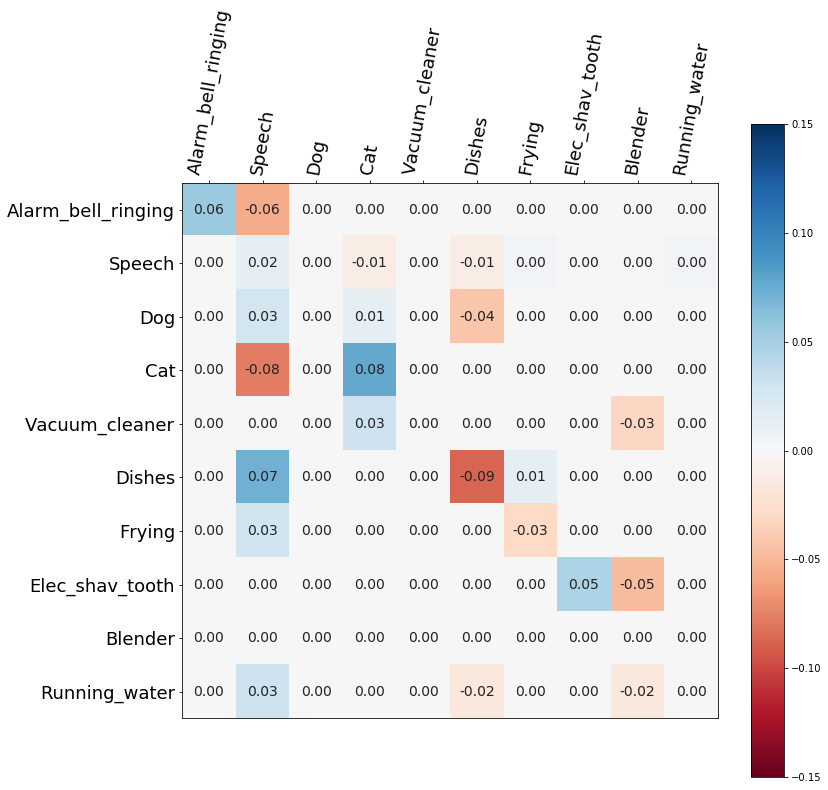

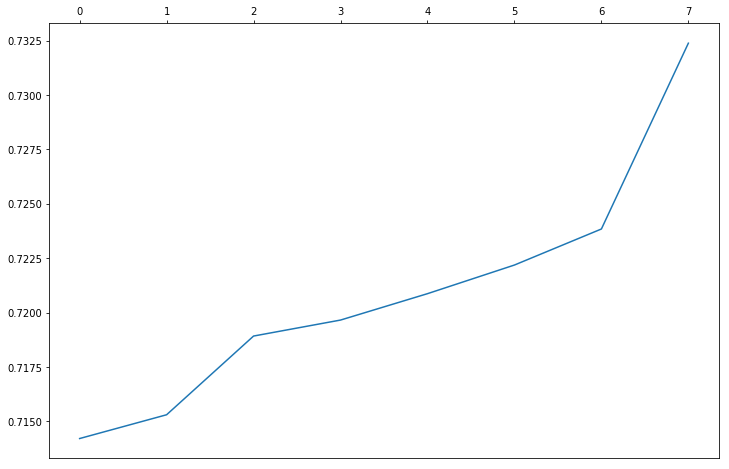

In [12]:
def applyThreshold(thresh) -> list:
    pred = copy.copy(prediction)
    
    for clsInd in range(len(pred.T)):
        pred.T[clsInd][pred.T[clsInd] > thresh[clsInd]] = 1
        pred.T[clsInd][pred.T[clsInd] <= thresh[clsInd]] = 0
        
    return pred

def initThresholds():
    return np.array([random.randint(40, 60) / 100 for _ in range(10)])

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def calcDelta(thresholds, weight):
    output = []
    for th in thresholds:
        g = gaussian(th, 0.5, 0.25)
        output.append((random.random() * 2*g - g) * weight)
    return np.array(output)

thresholds = [0.5 for _ in range(10)]
pred0 = applyThreshold(thresh=thresholds)
f10 = f1_score(pred0, vTrue, average=None)
r0 = recall_score(pred0, vTrue, average=None)
p0 = precision_score(pred0, vTrue, average=None)
init = {"thresholds": thresholds, "mean f1": f10.mean(), "mean r": r0.mean(), "mean p": p0.mean(), "f1" : f10}
best = {"thresholds": thresholds, "mean f1": f10.mean(), "mean r": r0.mean(), "mean p": p0.mean(), "f1" : f10}
curve = []


metaIter = 100
for j in range(metaIter):
    nbIter = 30
    nbIterTotal = nbIter * metaIter
    weight = 0.07
    decay = weight / (nbIter *1.9)
    thresholds = initThresholds()
    for i in range(nbIter):
        delta = calcDelta(thresholds, weight)
        thresholds += delta
        weight -= decay

        nPred = applyThreshold(thresholds)
        f1 = f1_score(nPred, vTrue, average=None)
        r = recall_score(nPred, vTrue, average=None)
        p = precision_score(nPred, vTrue, average=None)

        if f1.mean() > best["mean f1"]:
            best["thresholds"] = thresholds
            best["mean f1"] = f1.mean()
            best["mean r"] = r.mean()
            best["mean p"] = p.mean()
            best["f1"] = f1
            curve.append(f1.mean())

        percent = (j * nbIter + i) / nbIterTotal * 100
        clear_output(wait=True)
        print("best threshold with f1 mean of: %-*.4f, progress: %.2f %%" % (10, best["mean f1"], percent) )

print(weight)
print(thresholds)
print("original f1 mean: %.2f" % (init["mean f1"] * 100))
print("original recall: %.2f" %  (init["mean r"] * 100))
print("original precision: %.2f" %  (init["mean p"] * 100))
print("best f1 mean: %.2f" %  (best["mean f1"] * 100))
print("best recall: %.2f" %  (best["mean r"] * 100))
print("best precision: %.2f" %  (best["mean p"] * 100))
for clsInd in range(len(classes)):
    print(classes[clsInd], "%.4f" % thresholds[clsInd])
    
predLast = applyThreshold(thresholds)
conf0 = calcConfusion(pred0, False)
confn = calcConfusion(predLast, False)
displayConfusion(conf0 - confn, classes, "RdBu", bounds=(-0.15, 0.15))

plt.figure(figsize=(12, 8))
plt.plot(curve)

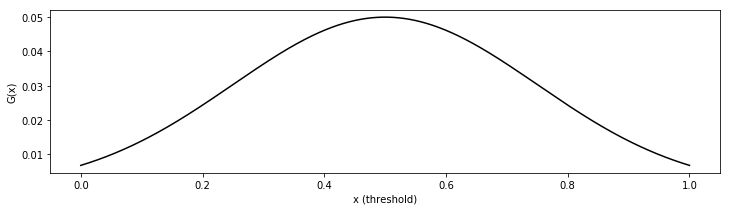

In [11]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

x = np.linspace(0.0, 1.0, 1000)
plt.figure(figsize=(12, 3))
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.xlabel("x (threshold)")
plt.ylabel("G(x)")
plt.plot(x, gaussian(x, 0.5, 0.25) * 0.05, color="black")